# Goals
The aim is to recreate FE versions of the test problems form the BICGStab paper and export them as mtx files.

## Set Up and Test
This is assembled from the Gridap tutorials.  It is set up to be as understandable as possible.  This just so that I can see where everything came from. 

The eigenfunctions and eigenvalues of $-\Delta u $ on the square domain $(0,1)^2$ with homogeneous Dirichlet conditions on all sides are 
$$
u_{i,j} = \sin(i x/\pi) s\sin(j y/\pi) \mbox{ with } \lambda_{i,j} = (i^2 + j^2)/\pi^2
$$
for integers $i$ and $j$.
This gives the sequence of smallest eigenvalues as 
$$
0.202642, 0.506606, 0.506606, 0.810569, 1.01321, 1.01321, 1.31718, 
1.31718, 1.72246, 1.72246, 1.82378, 2.02642, \dots 
$$
scaling them by he smallest eigenvalue we get the ratios
$$
1, 2, 2, 4, 5, 5, 6, 6, 8, 8, 9, 10, 10, 12, 12, 16, \dots
$$
The eigenvalues ratios are visbly correct below.  The values of the eigenvalues are not!  There is a uniform scaling hiding somewhere
that I am going to ignore. The lowest eigenvalues always converge faster than the higher ones. 


In [ ]:
using Gridap, LinearAlgebra, LimitedLDLFactorizations, Preconditioners, SparseArrays

n = 30; Omega = (0.0,1.0,0.0,1.0);
Grid = CartesianDiscreteModel(Omega, (n,n))
# Grid has 4 corners and 4 edges
# "boundary" is all elements of the boundary of Omega
# Tags 1-4 are the corners and Tags 5-8 are the edges.
# Label each of the six sides differently
# boundary
Tags = get_face_labeling(Grid)
add_tag_from_tags!(Tags,"y=0",[1,2,5])
add_tag_from_tags!(Tags,"OtherEdges",[3,4,6,7,8])
# Piecewise linear Lagrange elements
order = 1; Elements = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(Grid,Elements,conformity=:H1,dirichlet_tags="boundary")
# Incorporating Homogeneous Dirichlet boundary conditions.
g(x) = 0.0
U = TrialFESpace(V,g)
# Triangulating and defining measures
degree = 2
Ω = Triangulation(Grid)
dΩ = Measure(Ω,degree)
# Setting up a simple test problem
f(x) = 0.0
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
b(v) = ∫( v*f )*dΩ
# Set up FE operator
op = AffineFEOperator(a,b,U,V)
# Extract Stiffness Matrix A
A=get_matrix(op)
λs=eigen(Matrix(A)).values; 
λs[1:10]/λs[1]

We need to make sure that we are computing the incomplete Cholesky correctly as well. 

In [ ]:
# Compute Incomplete Cholesky Decomposition
# Dimensions needed to inhibit pivoting by specifying "natural order" 1:m 
# print(fieldnames(LimitedLDLFactorization))
m=size(A)[1]
LStructure = lldl(tril(A,-1), diag(A), 1:m, memory=1)
L=LStructure.L + I
D=spdiagm(LStructure.D)
# alpha should be zero and p should be the identity permutation
# \alpha then TAB produces pretty α
alpha=LStructure.α
p=LStructure.P
println("α=",alpha," p==1:m is ",p==1:m) 
# Check preconditioner quality
println("relative residual error L form is ", norm(A - L*D*L')/norm(A))
P=L*spdiagm(sqrt.(abs.(LStructure.D)));
println("relative residual error P form is ", norm(A - P*P')/norm(A))

# Problem 1
$-\Delta u$
All Homogeneous Dirichlet conditions. Assumption is that we have memory level 1. 

Output matrices are called A1 and P1

In [ ]:
using Gridap, LinearAlgebra, LimitedLDLFactorizations, Preconditioners, SparseArrays, MatrixMarket

n = 150; Omega = (0.0,1.0,0.0,1.0);
Grid = CartesianDiscreteModel(Omega, (n,n))
# Grid has 4 corners and 4 edges
# "boundary" is all elements of the boundary of Omega
# Tags 1-4 are the corners and Tags 5-8 are the edges.
# Label each of the six sides differently
# boundary
Tags = get_face_labeling(Grid)
add_tag_from_tags!(Tags,"y=0",[1,2,5])
add_tag_from_tags!(Tags,"OtherEdges",[3,4,6,7,8])
# Piecewise linear Lagrange elements
order = 1; Elements = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(Grid,Elements,conformity=:H1,dirichlet_tags="boundary")
# Incorporating Homogeneous Dirichlet boundary conditions.
g(x) = 0.0
U = TrialFESpace(V,g)
# Triangulating and defining measures
degree = 2
Ω = Triangulation(Grid)
dΩ = Measure(Ω,degree)
# Setting up a simple test problem
f(x) = 0.0
a(u,v) = ∫( ∇(v)⋅∇(u) )*dΩ
b(v) = ∫( v*f )*dΩ
# Set up FE operator
op = AffineFEOperator(a,b,U,V)
# Extract Stiffness Matrix and compute P1
A1=get_matrix(op)
# Compute Incomplete Cholesky Decomposition
# Dimensions needed to inhibit pivoting by specifying "natural order" 1:m 
# print(fieldnames(LimitedLDLFactorization))
m=size(A1)[1]
LStructure = lldl(tril(A1,-1), diag(A1), 1:m, memory=1)
L=LStructure.L + I
D=spdiagm(LStructure.D)
P1=L*spdiagm(sqrt.(abs.(LStructure.D)))
# Dump Matrices
mmwrite("A1.mtx",A1)
mmwrite("P1.mtx",P1)

# Problem 2
$-\nabla \cdot (D(x,y) *\nabla u)$
Homogeneous Dirichlet conditions only on y=0

In [ ]:
using Gridap, LinearAlgebra, LimitedLDLFactorizations, Preconditioners, SparseArrays, MatrixMarket

n = 150; Omega = (0.0,1.0,0.0,1.0);
Grid = CartesianDiscreteModel(Omega, (n,n))
# Grid has 4 corners and 4 edges
# "boundary" is all elements of the boundary of Omega
# Tags 1-4 are the corners and Tags 5-8 are the edges.
# Label each of the six sides differently
# boundary
Tags = get_face_labeling(Grid)
add_tag_from_tags!(Tags,"y=0",[1,2,5])
add_tag_from_tags!(Tags,"OtherEdges",[3,4,6,7,8])
# Piecewise linear Lagrange elements
order = 1; Elements = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(Grid,Elements,conformity=:H1,dirichlet_tags="y=0")
# Incorporating Homogeneous Dirichlet boundary conditions.
g(x) = 0.0
U = TrialFESpace(V,g)
# Triangulating and defining measures
degree = 2
Ω = Triangulation(Grid)
dΩ = Measure(Ω,degree)
# Setting up a simple test problem
f(x) = 0.0
function d(x)
    if (0.1 <x[1] && x[1]<0.9 && 0.1 <x[2] && x[2]<0.9) 
        1000.0
    else
        1.0
    end
end
a(u,v) = ∫(d*∇(v)⋅∇(u) )*dΩ
b(v) = ∫( v*f )*dΩ
# Set up FE operator
op = AffineFEOperator(a,b,U,V)
# Extract Stiffness Matrix and compute P1
A2=get_matrix(op)
# Compute Incomplete Cholesky Decomposition
# Dimensions needed to inhibit pivoting by specifying "natural order" 1:m 
# print(fieldnames(LimitedLDLFactorization))
m=size(A2)[1]
LStructure = lldl(tril(A2,-1), diag(A2), 1:m, memory=1)
L=LStructure.L + I
D=spdiagm(LStructure.D)
P2=L*spdiagm(sqrt.(abs.(LStructure.D)))
# Dump Matrices
mmwrite("A2.mtx",A2)
mmwrite("P2.mtx",P2)

Testing that d is defined correctly!

In [ ]:
(d([0.01 0.4]), d([0.2,0.4]))

# Problem 3
$-\Delta u + ((a u)_x + a u_x)/2 == 1$
with 
$n=201$ and $a=20 \exp(3.5(x^2+y^2))$. 
Dirichlet conditions on all edges.

I need to work out how to build the lower order terms (not as easy as it should be) 
and how to get the ILU. 

    - ilu0 does not give matrices!
    - IncompleteLU may be better.  It is but it is tolerance based!  There seems to be little fill in for $\tau=0.01$.

In [2]:
using Gridap, LinearAlgebra, IncompleteLU, Preconditioners, SparseArrays, MatrixMarket, IncompleteLU

n = 150; Omega = (0.0,1.0,0.0,1.0);
Grid = CartesianDiscreteModel(Omega, (n,n))
# Grid has 4 corners and 4 edges
# "boundary" is all elements of the boundary of Omega
# Tags 1-4 are the corners and Tags 5-8 are the edges.
# Label each of the six sides differently
# boundary
Tags = get_face_labeling(Grid)
add_tag_from_tags!(Tags,"y=0",[1,2,5])
add_tag_from_tags!(Tags,"OtherEdges",[3,4,6,7,8])
# Piecewise linear Lagrange elements
order = 1; Elements = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(Grid,Elements,conformity=:H1,dirichlet_tags="boundary")
# Incorporating Homogeneous Dirichlet boundary conditions.
g(x) = 0.0
U = TrialFESpace(V,g)
# Triangulating and defining measures
degree = 2
Ω = Triangulation(Grid)
dΩ = Measure(Ω,degree)
# Setting up a simple test problem
f(x) = 0.0
# The coefficient functions are called aFun to avoid name space collisions with the bi linear form 
function aFun(x)
    20.0*exp(3.5*(x[1]^2+x[2]^2))
end
# The needs to be a function to apply the composition trick in the 
# tutorials 
function FirstComp(v)
  v[1]
end
# Weak Form etc. 
# FirstComp∘∇(aFun*u) is pretty for Operation(FirstComponent)(∇(sFun*u)))
# \circ TAB gives the symbol "∘" 
# It needs the composition to make understand what it is being asked to build. 
a(u,v) = ∫(∇(v)⋅∇(u) )*dΩ + ∫(0.5*(FirstComp∘∇(aFun*u))*v)*dΩ + ∫(0.5*(aFun*(FirstComp∘∇(u)))*v)*dΩ
b(v) = ∫( v*f )*dΩ
# Set up FE operator
op = AffineFEOperator(a,b,U,V)
# Extract Stiffness Matrix and compute P1
A3=get_matrix(op)
# Compute ILU
LUfact = ilu(A3,τ=0.01)
# print(fieldnames(IncompleteLU.ILUFactorization))
L3 = LUfact.L+I; U3 = LUfact.U
# Dump Matrices
mmwrite("A3.mtx",A3)
mmwrite("L3.mtx",L3)
mmwrite("U3.mtx",U3)
L3

22201×22201 SparseMatrixCSC{Float64, Int64} with 342683 stored entries:
⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄

# Problem 4
$-\nabla \cdot (A(x,y) *\nabla u) + B(x,y)*u_x$
Homogeneous Dirichlet conditions on all edges with
$B(x,y)=2 \exp (2(x^2 +y^2)) $ 
and $A(x,y)$ large in the middle of the square surrounded by a 
moat of a small value with a bridge, and surrounded by a moderately 
larege value.  The is no real detail given $n=128$. 

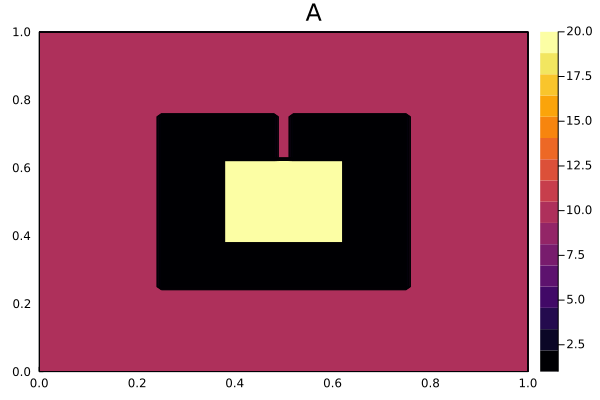

In [21]:
using Gridap, LinearAlgebra, IncompleteLU, Preconditioners, SparseArrays, MatrixMarket, IncompleteLU

n = 15; Omega = (0.0,1.0,0.0,1.0);
Grid = CartesianDiscreteModel(Omega, (n,n))
# Grid has 4 corners and 4 edges
# "boundary" is all elements of the boundary of Omega
# Tags 1-4 are the corners and Tags 5-8 are the edges.
# Label each of the six sides differently
# boundary
Tags = get_face_labeling(Grid)
add_tag_from_tags!(Tags,"y=0",[1,2,5])
add_tag_from_tags!(Tags,"OtherEdges",[3,4,6,7,8])
# Piecewise linear Lagrange elements
order = 1; Elements = ReferenceFE(lagrangian,Float64,order)
V = TestFESpace(Grid,Elements,conformity=:H1,dirichlet_tags="boundary")
# Incorporating Homogeneous Dirichlet boundary conditions.
g(x) = 0.0
U = TrialFESpace(V,g)
# Triangulating and defining measures
degree = 2
Ω = Triangulation(Grid)
dΩ = Measure(Ω,degree)
# Setting up a simple test problem
f(x) = 0.0
# Coefficient functions
# I am interpreting figure 4 for A
# bridge 0.1 wide, moat 0.25 wide moat between 2/8 and 3/8 
function A(x,y)
    a=0.25;b=0.125;c=0.02
    if (x<a || x > 1 - a || y < a|| y > 1 - a) return(10)
    end
    if (abs(x - 1/2) <= c && 0.5 + b <= y) return(10)
    end
    if (abs(x - 1/2) <= b && abs(y - 1/2) <= b) return(20)
    end
    return(1)
end
using Plots
contour(0.0:0.01:1.0,0.0:0.01:1.0 , A, fill=true, plot_title="A")

In [56]:
function B(x)
    2.0*exp(2.0*(x[1]^2+x[2]^2))
end
# The needs to be a function to apply the composition trick in the 
# tutorials 
function FirstComp(v)
  v[1]
end
# Weak Form etc. 
# FirstComp∘∇(aFun*u) is pretty for Operation(FirstComponent)(∇(sFun*u)))
# \circ TAB gives the symbol "∘" 
# It needs the composition to make understand what it is being asked to build. 
a(u,v) = ∫(∇(v)⋅∇(u) )*dΩ + ∫(0.5*(FirstComp∘∇(aFun*u))*v)*dΩ + ∫(0.5*(aFun*(FirstComp∘∇(u)))*v)*dΩ
b(v) = ∫( v*f )*dΩ
# Set up FE operator
op = AffineFEOperator(a,b,U,V)
# Extract Stiffness Matrix and compute P1
A3=get_matrix(op)
# Compute ILU
LUfact = ilu(A3,τ=0.01)
# Dimensions needed to inhibit pivoting by specifying "natural order" 1:m 
# print(fieldnames(IncompleteLU.ILUFactorization))
L3 = LUfact.L+I; U3 = LUfact.U
# Dump Matrices
mmwrite("A3.mtx",A3)
mmwrite("L3.mtx",L3)
mmwrite("U3.mtx",U3)

FirstComp (generic function with 1 method)